In [1]:
from keras_dna import Generator, ModelWrapper, MultiGenerator
import tensorflow.keras as keras

In [2]:
from keras_dna.sequence import SeqIntervalDl, StringSeqIntervalDl
import os
os.chdir('tutorial_dr')

# Regression problem

To experiment the possible usage of `keras_dna` in the context of regression, we will train a neural network to predict the nucleosome density in $\textit{S.cerevisiae}$ directly from the DNA sequence.

#### Downloading the data

The data needed are :
- the DNA sequence in a fasta file.
- an experimental nucleosome coverage in bigwig format.

In [2]:
!mkdir tutorial_dr
os.chdir('tutorial_dr')

!wget http://hgdownload.soe.ucsc.edu/goldenPath/sacCer3/bigZips/sacCer3.fa.gz
!gunzip sacCer3.fa
!wget http://bigd.big.ac.cn/nucmap/NucMap_FTP_Directory/Saccharomyces_cerevisiae/bySample/scNuc0010101/Saccharomyces_cerevisiae.scNuc0010101.nucleosome.shift.bw
!mv Saccharomyces_cerevisiae.scNuc0010101.nucleosome.shift.bw scerevisiae.bw

mkdir: impossible de créer le répertoire « tutorial_dr »: File exists
--2020-04-29 11:02:56--  http://hgdownload.soe.ucsc.edu/goldenPath/sacCer3/bigZips/sacCer3.fa.gz
Résolution de hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)… 128.114.119.163
Connexion à hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:80… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 3820548 (3.6M) [application/x-gzip]
Sauvegarde en : « sacCer3.fa.gz »

sacCer3.fa.gz       100%[===================>]   3.64M  1.10MB/s    ds 4.7s    

2020-04-29 11:03:01 (798 KB/s) — « sacCer3.fa.gz » sauvegardé [3820548/3820548]

gzip: sacCer3.fa: unknown suffix -- ignored
--2020-04-29 11:03:01--  http://bigd.big.ac.cn/nucmap/NucMap_FTP_Directory/Saccharomyces_cerevisiae/bySample/scNuc0010101/Saccharomyces_cerevisiae.scNuc0010101.nucleosome.shift.bw
Résolution de bigd.big.ac.cn (bigd.big.ac.cn)… 124.16.129.109
Connexion à bigd.big.ac.cn (bigd.big.ac.cn)|124.16.129.109|:80… connecté.


#### Building a 1d CNN with keras

We build a 1d convolutionnal network with three convolutionnal layers. This model will be trained to predict the nucleosome density at the center of a 2001 bp DNA window. 

The models inputs are of shape (batch_size, 2001, 4). The outputs are of shape (batch_size, 1).

In [24]:
model = keras.models.Sequential()

model.add(keras.layers.Conv1D(16, 3, activation='relu', input_shape=(2001, 4)))
model.add(keras.layers.MaxPooling1D(2))

model.add(keras.layers.Conv1D(32, 10, activation='relu'))
model.add(keras.layers.MaxPooling1D(2))

model.add(keras.layers.Conv1D(64, 20, activation='relu'))
model.add(keras.layers.MaxPooling1D(2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, activation='linear'))
          
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [3]:
early = keras.callbacks.EarlyStopping(monitor='val_loss',
                                      min_delta=0,
                                      patience=10,
                                      verbose=0,
                                      mode='auto')

### Train the model

We use `Generator` class to feed the train set data to our model. One needs to pass the DNA sequence in a fasta file, the nucleosome density in bigwig. One needs to specify the batch size (here 64) and the length of input windows (2001 bp).

In this example we restrict our train set to the 6 first chromosomes and the output_shape is specified to correspond to the model output.

In [31]:
generator_train = Generator(batch_size=64,
                            fasta_file='sacCer3.fa',
                            annotation_files=['scerevisiae.bw'],
                            window=2001,
                            incl_chromosomes=['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI'],
                            output_shape=(64, 1),
                            rc=True)

We can now associate the model to its specific train generator in a `ModelWrapper` instance. In this case we will also associate another `Generator` to our model : the validation generator. This generator is used in the validation process and yields data coming from chromosome 7 and 8.

In [32]:
wrap = ModelWrapper(model=model,
                    generator_train=generator_train,
                    validation_chr=['chrVII', 'chrVIII'])

In [35]:
generator = wrap.predict(incl_chromosomes=['chrIX'],
                         chrom_size='sacCer3.chrom.sizes',
                         rc=True)

Just use the `train` method to train the model. One can also pass arguments that will be used by the keras model method [fit_generator](https://keras.io/models/sequential/)

In [11]:
wrap.train(epochs=100,
           steps_per_epoch=500,
           validation_steps=200,
           callbacks=[early])

Evaluation can be made on a new chromosome with the method `evaluate`. Arguments can be passed to the keras model method [evaluate_generator](https://keras.io/models/sequential/).

In [15]:
wrap.evaluate(incl_chromosomes=['chrM'], verbose=1)

1309/1309 [==============================] - 81s 62ms/step - loss: 47.6814 - mae: 1.1979


AttributeError: 'Sequential' object has no attribute 'metric_names'

We can also specificaly calculate the correlation between the predicted and experimental nucleosome density. Use the method `get_correlation` to do so. It also use internally the evaluate_generator keras method.

In [ ]:
wrap.get_correlation(incl_chromosomes=['chrM'], verbose=1)

#### Normalization of the inputs

As nucleosome density is an experimental data, one needs to normalize it for comparison purpose. It is also a good practise to remove outliers before calculating any metrics. Here we will cut the distribution to the last percentile and divide by the resulant maximum.

To do so we ude the keyword normalization_mode.

In [10]:
generator_train = Generator(batch_size=64,
                            fasta_file='sacCer3.fa',
                            annotation_files=['scerevisiae.bw'],
                            window=2001,
                            normalization_mode=['max', 'perctrim'],
                            incl_chromosomes=['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI'],
                            output_shape=(64, 1))

In [11]:
wrap = ModelWrapper(model=model,
                    generator_train=generator_train,
                    validation_chr=['chrVII', 'chrVIII'])

In [8]:
wrap.train(epochs=100,
           steps_per_epoch=500,
           validation_steps=200,
           callbacks=[early])

In [ ]:
wrap.evaluate(incl_chromosomes=['chrIX'], verbose=1)

In [10]:
wrap.get_correlation(incl_chromosomes=['chrIX'], verbose=1)

#### Adding weights to balance the training process

The distribution of score of nucleosome density is not flat, it means that rare score will tend to be ill predicted by the model because they account for virtualy nothing in the loss function. To compensate this fact an usual strategy is to add weights during the training for the loss calculation.

To balance the relative importance of scores one can pass 'balanced' to the weighting_mode keyword.

In [14]:
generator_train = Generator(batch_size=64,
                            fasta_file='sacCer3.fa',
                            annotation_files=['scerevisiae.bw'],
                            window=2001,
                            normalization_mode=['max', 'perctrim'],
                            incl_chromosomes=['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI'],
                            weighting_mode='balanced',
                            output_shape=(64, 1))

Set the keyword weights_val to specify that one wants to apply the weights to calculate metrics on the validation set.

In [15]:
wrap = ModelWrapper(model=model,
                    generator_train=generator_train,
                    validation_chr=['chrVII', 'chrVIII'],
                    weights_val=True)

In [ ]:
wrap.train(epochs=100,
           steps_per_epoch=500,
           validation_steps=200,
           callbacks=[early])

During the evaluation process one can specify if one wants to include weights with the keyword weights_eval.

In [26]:
wrap.evaluate(incl_chromosomes=['chrIX'], verbose=1, weights_eval=False)

In [16]:
wrap.get_correlation(incl_chromosomes=['chrIX'], verbose=1, weights_eval=False)

### Saving model

We can save the `ModelWrapper` instance in a hdf5 file with the methos `save`.

Be aware, as it is usual to save the best model obtained during the training process (with the keras callbacks [ModelCheckpoint](https://keras.io/callbacks/)), one may not want to overwrite the model at the end of training. To prevent the method from overwritting the model, set the keyword save_model to False (default behaviour).

In [17]:
wrap.save('./weights_CNN_nucleosome_normalized_weighted.hdf5',
          save_model=True)

### Loading a `ModelWrapper` instance

In [4]:
from keras_dna.model import load_wrapper, load_generator_command

First situation, one wants to reuse a `ModelWrapper` instance and to reuse both the model and the data, furthermore the path to access the data is unchanged since saving time.  

The method `load_wrapper` loads both the model and the generator with the original data, the path to access data must therefore be unchanged.

In [5]:
wrapper = load_wrapper('./weights_CNN_nucleosome_normalized_weighted.hdf5')

We can work with the loaded instance as usual.

In [20]:
wrapper.get_correlation(incl_chromosomes=['chrIX'], verbose=1, weights_eval=False)

Second situtation, we want to reuse the model of a `ModelWrapper` but with new data (or just because their localisation has changed since saving). The module `load_generator_command` gives us access to a tuple of dictionaries that can be used to recreate the training and validation generators.

As an exemple we will reuse our saved model and calculate the correlation of its prediction with a new experimental nucleosome density.

First, we need to downlaod the new data. Then, we can download the dictionaries to see how to create train and validation generators adapted to the model and then load the model with the keras method `load_model`.

In [26]:
!wget http://bigd.big.ac.cn/nucmap/NucMap_FTP_Directory/Saccharomyces_cerevisiae/bySample/scNuc0020101/Saccharomyces_cerevisiae.scNuc0020101.nucleosome.shift.bw
!mv Saccharomyces_cerevisiae.scNuc0020101.nucleosome.shift.bw scerevisiae2.bw

--2020-05-01 11:32:30--  http://bigd.big.ac.cn/nucmap/NucMap_FTP_Directory/Saccharomyces_cerevisiae/bySample/scNuc0020101/Saccharomyces_cerevisiae.scNuc0020101.nucleosome.shift.bw
Résolution de bigd.big.ac.cn (bigd.big.ac.cn)… 124.16.129.109
Connexion à bigd.big.ac.cn (bigd.big.ac.cn)|124.16.129.109|:80… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 2525167 (2.4M) [text/plain]
Sauvegarde en : « Saccharomyces_cerevisiae.scNuc0020101.nucleosome.shift.bw »

Saccharomyces_cerev 100%[===================>]   2.41M  1.85MB/s    ds 1.3s    

2020-05-01 11:32:32 (1.85 MB/s) — « Saccharomyces_cerevisiae.scNuc0020101.nucleosome.shift.bw » sauvegardé [2525167/2525167]



In [29]:
command_train, command_val = load_generator_command('./weights_CNN_nucleosome_normalized_weighted.hdf5')
command_train

{'type': 'Generator',
 'arguments': {'batch_size': 64,
  'one_hot_encoding': True,
  'output_shape': [64, 1],
  'weighting_mode': 'balanced',
  'bins': 'auto',
  'fasta_file': 'sacCer3.fa',
  'annotation_files': ['scerevisiae.bw'],
  'window': 2001,
  'normalization_mode': ['max', 'perctrim'],
  'incl_chromosomes': ['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI']}}

In [25]:
model = keras.models.load_model('./weights_CNN_nucleosome_normalized_weighted.hdf5')

Change the name of the bigwig file in the dictionnary to evaluate the same model on a new data. (can especially be useful for transfer learning).

In [30]:
command_train = command_train['arguments']
command_val = command_val['arguments']

command_train['annotation_files'] = ['scerevisiae2.bw']
command_val['annotation_files'] = ['scerevisiae2.bw']
command_train

{'batch_size': 64,
 'one_hot_encoding': True,
 'output_shape': [64, 1],
 'weighting_mode': 'balanced',
 'bins': 'auto',
 'fasta_file': 'sacCer3.fa',
 'annotation_files': ['scerevisiae2.bw'],
 'window': 2001,
 'normalization_mode': ['max', 'perctrim'],
 'incl_chromosomes': ['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI']}

In [31]:
generator_train = Generator(**command_train)
generator_val = Generator(**command_val)

wrap = ModelWrapper(model=model,
                    generator_train=generator_train,
                    generator_val=generator_val)

In [34]:
wrap.get_correlation(incl_chromosomes=['chrIX'], verbose=1)

Note that the module `get_correlation` owns keywords to do cross-prediction without the need of recreating totally new generators by hand (not `evaluate`)

For example, say we want to evaluate if our model trained on S.cerevisiae is able to predict the nucleosome density on C.elegans. We will download the C.elegans genome as well as an experimental nucleosome density and calculate the correlation between the predicted density and the experimental one.

In [7]:
!wget https://hgdownload.soe.ucsc.edu/goldenPath/ce11/bigZips/ce11.fa.gz
!gunzip ce11.fa.gz
!wget http://bigd.big.ac.cn/nucmap/NucMap_FTP_Directory/Caenorhabditis_elegans/bySample/ceNuc0010101/Caenorhabditis_elegans.ceNuc0010101.nucleosome.shift.bw
!mv Caenorhabditis_elegans.ceNuc0010101.nucleosome.shift.bw celegans.bw

--2020-05-01 14:39:24--  https://hgdownload.soe.ucsc.edu/goldenPath/ce11/bigZips/ce11.fa.gz
Résolution de hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)… 128.114.119.163
Connexion à hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 31816111 (30M) [application/x-gzip]
Sauvegarde en : « ce11.fa.gz »

ce11.fa.gz          100%[===================>]  30.34M  8.44MB/s    ds 6.8s    

2020-05-01 14:39:32 (4.47 MB/s) — « ce11.fa.gz » sauvegardé [31816111/31816111]

gzip: cell.fa.gz: No such file or directory
--2020-05-01 14:39:32--  http://bigd.big.ac.cn/nucmap/NucMap_FTP_Directory/Caenorhabditis_elegans/bySample/ceNuc0010101/Caenorhabditis_elegans.ceNuc0010101.nucleosome.shift.bw
Résolution de bigd.big.ac.cn (bigd.big.ac.cn)… 124.16.129.109
Connexion à bigd.big.ac.cn (bigd.big.ac.cn)|124.16.129.109|:80… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 19735260 (19M) 

One needs to pass the fasta file as well as the bigwig file to the `get_correlation` method.

In [5]:
wrap.get_correlation(incl_chromosomes=['chrM'],
                     fasta_file='ce11.fa',
                     annotation_files=['celegans.bw'],
                     verbose=1)

184/184 [==============================] - 13s 72ms/step - loss: 66987.2414 - metric: 0.0211


{'correlate_0_0': 0.021094829}

### Prediction on a full chromosomes

Use the method `predict` to predict the nucleosome density on full chromosomes, this prediction can be exported to a bigwig file (if a path is passed as argument). One needs to pass a file with chromosome size in two columns tab separated to the method, its name should end with .chrom.sizes.

In [35]:
!wget https://hgdownload.soe.ucsc.edu/goldenPath/sacCer3/bigZips/sacCer3.chrom.sizes

--2020-05-01 11:46:06--  https://hgdownload.soe.ucsc.edu/goldenPath/sacCer3/bigZips/sacCer3.chrom.sizes
Résolution de hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)… 128.114.119.163
Connexion à hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 229 [text/plain]
Sauvegarde en : « sacCer3.chrom.sizes »

sacCer3.chrom.sizes 100%[===================>]     229  --.-KB/s    ds 0s      

2020-05-01 11:46:07 (3.46 MB/s) — « sacCer3.chrom.sizes » sauvegardé [229/229]



In [6]:
prediction = wrap.predict(incl_chromosomes=['chrIX', 'chrX'],
                          chrom_size='sacCer3.chrom.sizes',
                          export_to_path='prediction_chrIX_chrX.bw',
                          verbose=1)

36926/36926 [==============================] - 1010s 27ms/step


We can also predict on a different genome for example C.elegans with the model trained on S.cerevisiae.

In [13]:
!wget https://hgdownload.soe.ucsc.edu/goldenPath/ce11/bigZips/ce11.chrom.sizes

--2020-05-01 14:42:28--  https://hgdownload.soe.ucsc.edu/goldenPath/ce11/bigZips/ce11.chrom.sizes
Résolution de hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)… 128.114.119.163
Connexion à hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 99 [text/plain]
Sauvegarde en : « ce11.chrom.sizes »

ce11.chrom.sizes    100%[===================>]      99  --.-KB/s    ds 0s      

2020-05-01 14:42:29 (3.42 MB/s) — « ce11.chrom.sizes » sauvegardé [99/99]



We can also predict and export the prediction in a cross-species context. One just needs to pass the genome of the new species in a fasta file as well as the adapted chromosome sizes.

In [7]:
prediction = wrap.predict(incl_chromosomes=['chrM'],
                          chrom_size='ce11.chrom.sizes',
                          fasta_file='ce11.fa',
                          export_to_path='prediction_celegans.bw',
                          verbose=1)

368/368 [==============================] - 10s 28ms/step


Finally, we can predict the nucleosome density with the reversed complemented DNA sequence.

In [ ]:
prediction = wrap.predict(incl_chromosomes=['chrM'], chrom_size='sacCer3.chrom.sizes', rc=True, verbose=1)

### Training with multiple inputs / outputs

#### Training with another tracks as input

To demonstrate this functionnality we will train a model that takes DNA windows of 2001 bp as inputs as well as the nucleosome density of the 100 centers nucleotides coming from one experiment and predict the the same nucleosome density for another experiment. It is somehow an experiment translators.

Let's create a multi input model.

In [3]:
dna_extractor = keras.models.Sequential()

dna_extractor.add(keras.layers.Conv1D(16, 3, activation='relu', input_shape=(2001, 4)))
dna_extractor.add(keras.layers.MaxPooling1D(2))

dna_extractor.add(keras.layers.Conv1D(32, 10, activation='relu'))
dna_extractor.add(keras.layers.MaxPooling1D(2))

dna_extractor.add(keras.layers.Conv1D(64, 20, activation='relu'))
dna_extractor.add(keras.layers.MaxPooling1D(2))

dna_extractor.add(keras.layers.Flatten())

dna_inputs = keras.layers.Input(shape=(2001, 4))
seq_inputs = keras.layers.Input(shape=(100,))

dna_features = dna_extractor(dna_inputs)
concatenate = keras.layers.Concatenate()([dna_features, seq_inputs])
outputs = keras.layers.Dense(100)(concatenate)

model = keras.models.Model([dna_inputs, seq_inputs], outputs)
model.compile(loss='mse', optimizer='adam')

Then we create the corresponding `Generator` instance in order to feed the model with training data. Note that we use a serie of keyword begining by seq to control the secondary input.

In [4]:
generator_train = Generator(batch_size=64,
                            fasta_file='sacCer3.fa',
                            annotation_files=['scerevisiae.bw'],
                            window=2001,
                            tg_window=100,
                            normalization_mode=['max', 'perctrim'],
                            incl_chromosomes=['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI'],
                            output_shape=(64, 100),
                            sec_inputs=['scerevisiae2.bw'],
                            sec_input_length=100,
                            sec_input_shape=(64, 100),
                            sec_normalization_mode=['max', 'perctrim'],
                            use_sec_as='inputs')

The process is now transparent, we can create a `ModelWrapper` instance, train and evaluate it.

In [5]:
wrap = ModelWrapper(model=model,
                    generator_train=generator_train,
                    validation_chr=['chrVII', 'chrVIII'])

In [27]:
wrap.train(epochs=5,
           steps_per_epoch=500,
           validation_steps=200)

Epoch 1/5
500/500 [==============================] - 64s 129ms/step - loss: 0.0202 - val_loss: 0.0120
Epoch 2/5
500/500 [==============================] - 64s 127ms/step - loss: 0.0113 - val_loss: 0.0094
Epoch 3/5
500/500 [==============================] - 63s 127ms/step - loss: 0.0090 - val_loss: 0.0087
Epoch 4/5
500/500 [==============================] - 64s 128ms/step - loss: 0.0085 - val_loss: 0.0084
Epoch 5/5
500/500 [==============================] - 63s 127ms/step - loss: 0.0085 - val_loss: 0.0090


In [31]:
wrap.get_correlation(incl_chromosomes=['chrIX'], verbose=1)

68/68 [==============================] - 6s 89ms/step - loss: 0.0099 - metric: 0.9362 1s - los


{'correlate_0_0': 0.9361512}

#### Predicting two tracks at the same time

As we saw previously, the nucleosome density can change from one experiment to another. We may want to predict several experimental densities at the same time. 

Here we create a model to predict the nucleosome density at the 100 center nucleotides of every 2001 bp DNA window. We will also predict two experimental densities at the same time.

In [6]:
output_track1 = keras.layers.Dense(100)(dna_features)
output_track1 = keras.layers.Reshape((100, 1))(output_track1)

output_track2 = keras.layers.Dense(100)(dna_features)
output_track2 = keras.layers.Reshape((100, 1))(output_track2)

output = keras.layers.Concatenate(axis=2, name='output')([output_track1, output_track2])
model = keras.models.Model(dna_inputs, output)

model.compile(loss='mse', optimizer='adam')

The only difference is that now we pass two bigwig files to the keyword annotation_files.

In [7]:
generator_train = Generator(batch_size=64,
                            fasta_file='sacCer3.fa',
                            annotation_files=['scerevisiae.bw', 'scerevisiae2.bw'],
                            window=2001,
                            tg_window=100,
                            normalization_mode=['max', 'perctrim'],
                            incl_chromosomes=['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI'],
                            output_shape=(64, 100, 2))

In [8]:
wrap = ModelWrapper(model=model,
                    generator_train=generator_train,
                    validation_chr=['chrVII', 'chrVIII'])

In [6]:
wrap.train(epochs=1,
           steps_per_epoch=500,
           validation_steps=200)

500/500 [==============================] - 62s 125ms/step - loss: 0.0458 - val_loss: 0.0344


`get_correlation` will display the correlation between every predicted density and its corresponding experimental one. As a contrary `evaluate` calculate the mean evaluation on all tracks.

In [6]:
wrap.get_correlation(incl_chromosomes=['chrIX'], verbose=1)

68/68 [==============================] - 7s 100ms/step - loss: 0.1910 - correlate_0_0: 0.0031 - correlate_1_0: 2.8998e-04


{'correlate_0_0': 0.003099391, 'correlate_1_0': 0.00028997537}

The method `predict` will in this case export one bigwig file for every prediction made by the model.

In [7]:
prediction = wrap.predict(incl_chromosomes=['chrIX'],
                          export_to_path='prediction_multi_training.bw',
                          chrom_size='sacCer3.chrom.sizes',
                          verbose=1)

136/136 [==============================] - 5s 40ms/step


### Training on several species simultaneously

`keras_dna` makes it easy to use model in a cross species context. To go a step further we want to predict the nucleosome density on both $\textit{S.cerevisiae}$ and $\textit{C.elegans}$ at the same time.

To do so we will use two new classes `SeqIntervalDl` and `MultiGenerator`.

In [3]:
from keras_dna import SeqIntervalDl, MultiGenerator

The model takes a DNA window of 2001 bp as input and predict the nucleosome density on the 100 centers nucleotides of the window.

In [4]:
model = keras.models.Sequential()

model.add(keras.layers.Conv1D(16, 3, activation='relu', input_shape=(2001, 4)))
model.add(keras.layers.MaxPooling1D(2))

model.add(keras.layers.Conv1D(32, 10, activation='relu'))
model.add(keras.layers.MaxPooling1D(2))

model.add(keras.layers.Conv1D(64, 20, activation='relu'))
model.add(keras.layers.MaxPooling1D(2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='linear'))
          
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

##### Creating the `MultiGenerator` instance

The process of creating a `MultiGeneraor` is not as straighforward as for a `Generator`.

One needs first to create a dataset (`SeqIntervalDl` instance) for every species, the keyword are the same as with a `Generator` except batch_size and output_shape that will be passed to the `MultiGenerator`.

The `MultiGenerator` is created by passing it the list of dataset. In our example we also pass the number of exemples that we want our generator to yield from every species.

In [5]:
dataset_saccer = SeqIntervalDl(fasta_file='sacCer3.fa',
                               annotation_files='scerevisiae.bw',
                               normalization_mode=['max', 'perctrim'],
                               window=2001,
                               tg_window=100,
                               rc=True,
                               incl_chromosomes=['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI'])

dataset_celegand = SeqIntervalDl(fasta_file='ce11.fa',
                                 annotation_files='celegans.bw',
                                 normalization_mode=['max', 'perctrim'],
                                 window=2001,
                                 tg_window=100,
                                 incl_chromosomes=['chrI', 'chrII'])

generator_train = MultiGenerator(batch_size=64,
                                 dataset_list=[dataset_saccer, dataset_celegand],
                                 inst_per_dataset=[64*500, 64*500],
                                 output_shape=(64, 100))

The same procedure apply for the cretion of the validation generator.

In [6]:
dataset_saccer_val = SeqIntervalDl(fasta_file='sacCer3.fa',
                                   annotation_files='scerevisiae.bw',
                                   normalization_mode=['max', 'perctrim'],
                                   window=2001,
                                   tg_window=100,
                                   incl_chromosomes=['chrVII', 'chrVIII'])

dataset_celegand_val = SeqIntervalDl(fasta_file='ce11.fa',
                                     annotation_files='celegans.bw',
                                     normalization_mode=['max', 'perctrim'],
                                     window=2001,
                                     tg_window=100,
                                     incl_chromosomes=['chrIII'])

generator_val = MultiGenerator(batch_size=64,
                               dataset_list=[dataset_saccer_val, dataset_celegand_val],
                               inst_per_dataset=[64*200, 64*200],
                               output_shape=(64, 100))

In [7]:
wrap = ModelWrapper(model=model,
                    generator_train=generator_train,
                    generator_val=generator_val)

In [17]:
wrap.train(epochs=1)

Finally if we want to evaluate our generator we need to specify the species.

The method `evaluate` requires to create a new generator to yield the testing data.

In [17]:
generator_test = Generator(batch_size=64,
                           fasta_file='sacCer3.fa',
                           annotation_files='scerevisiae.bw',
                           normalization_mode=['max', 'perctrim'],
                           window=2001,
                           tg_window=100,
                           incl_chromosomes=['chrM'],
                           output_shape=(64, 100))

In [19]:
wrap.evaluate(generator_eval=generator_test, verbose=1)

The method `get_correlation` requires to pass the genome we want to predict on and the nucleosome density we want to compare with.

In [7]:
wrap.get_correlation(incl_chromosomes=['chrX'],
                     fasta_file='sacCer3.fa',
                     annotation_files=['scerevisiae.bw'],
                     verbose=1)

116/116 [==============================] - 9s 75ms/step - loss: 0.1759 - metric: -0.0021


{'correlate_0_0': -0.0020717818}

The method `predict` requires to pass the genome we want to predict on as well as the corresponding chromosome sizes file.

In [12]:
wrap.predict(incl_chromosomes=['chrX'],
             chrom_size='sacCer3.chrom.sizes',
             fasta_file='sacCer3.fa',
             export_to_path='multi_prediction.bw',
             verbose=1)

232/232 [==============================] - 7s 29ms/step


array([[ 0.01883128, -0.04754147, -0.0131825 , ...,  0.13192448,
        -0.04590571, -0.0558481 ],
       [-0.02511727,  0.1061755 , -0.02488164, ...,  0.10167224,
         0.0442229 , -0.15225634],
       [-0.09656224, -0.05785175,  0.01321044, ...,  0.13336149,
         0.09787058, -0.0496234 ],
       ...,
       [-0.12513319,  0.13154107, -0.11106987, ...,  0.09564744,
         0.03229365, -0.08686507],
       [-0.05958488,  0.01612343, -0.07622039, ...,  0.18101265,
        -0.0049902 , -0.08667748],
       [-0.07636375,  0.03420825, -0.01399545, ...,  0.129873  ,
         0.05479156, -0.03051661]], dtype=float32)

# Classification problem

In this part we will classify DNA sequence between being a binding site for a transcription factor from being background. We will use binding site of a proteins called TAF15 in human genome. The sites as defined as peaks of Chip-Seq.

First, we will download the data, then create a convolutional classifier and finally create a `Generator` instance adapted to our model and data.

#### Downloading the data

In [20]:
!wget https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
!gunzip hg38.fa.gz

!wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE105nnn/GSE105202/suppl/GSE105202_ENCFF979TPQ_peaks_GRCh38.bed.gz
!gunzip GSE105202_ENCFF979TPQ_peaks_GRCh38.bed.gz
!mv GSE105202_ENCFF979TPQ_peaks_GRCh38.bed taf15.bed

--2020-05-07 10:45:03--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE105nnn/GSE105202/suppl/GSE105202_ENCFF979TPQ_peaks_GRCh38.bed.gz
Résolution de ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)… 130.14.250.7, 2607:f220:41e:250::10
Connexion à ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.7|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 6235743 (5.9M) [application/x-gzip]
Sauvegarde en : « GSE105202_ENCFF979TPQ_peaks_GRCh38.bed.gz »

GSE105202_ENCFF979T 100%[===================>]   5.95M  6.76MB/s    ds 0.9s    

2020-05-07 10:45:05 (6.76 MB/s) — « GSE105202_ENCFF979TPQ_peaks_GRCh38.bed.gz » sauvegardé [6235743/6235743]



Let's study the bed file to see what is the number of available positive annotatio and the typical length of a Chip-Seq peak. We are also interested in the distribution of peaks in chromosomes.

In [4]:
import pandas as pd

bedfile = pd.read_csv('taf15.bed', sep='\t', names=['chrom', 'start', 'stop', '0', '1', '2', '3', '4', '5', '6'])
bedfile.head()

,chrom,start,stop,0,1,2,3,4,5,6
0,chr2,195656836,195657387,.,0,.,366.644608,-1,3.198382,312
1,chr2,148645132,148645562,.,0,.,323.084459,-1,3.198382,260
2,chr7,35800963,35801305,.,0,.,289.978500,-1,3.198382,185
3,chr10,95656633,95656950,.,0,.,269.324547,-1,3.198382,158
4,chr7,26200724,26201117,.,0,.,258.250077,-1,3.198382,148


In [36]:
len(bedfile)

300000

In [38]:
bedfile['length'] = bedfile.stop.values - bedfile.start.values
bedfile.length.max(), bedfile.length.min(), round(bedfile.length.mean()), round(bedfile.length.std())

(551, 120, 404.0, 2.0)

(390.0, 410.0)

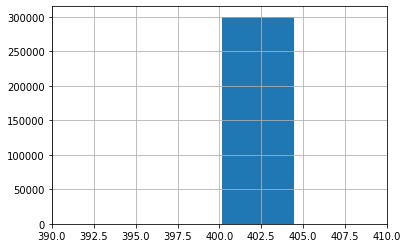

In [39]:
ax = bedfile.length.hist(bins=100)
ax.set_xlim(390, 410)

In [46]:
len(bedfile[bedfile.length == 404])

299961

In [49]:
for i in range(1, 22):
    print('number of peaks on chromosome {}: {}'.format(i, len(bedfile[bedfile.chrom == 'chr' + str(i)])))


number of peaks on chromosome 1: 33264
number of peaks on chromosome 2: 23056
number of peaks on chromosome 3: 16904
number of peaks on chromosome 4: 16387
number of peaks on chromosome 5: 18490
number of peaks on chromosome 6: 21000
number of peaks on chromosome 7: 22871
number of peaks on chromosome 8: 13834
number of peaks on chromosome 9: 10067
number of peaks on chromosome 10: 13201
number of peaks on chromosome 11: 15203
number of peaks on chromosome 12: 12347
number of peaks on chromosome 13: 4693
number of peaks on chromosome 14: 5367
number of peaks on chromosome 15: 8144
number of peaks on chromosome 16: 11585
number of peaks on chromosome 17: 11829
number of peaks on chromosome 18: 6147
number of peaks on chromosome 19: 12005
number of peaks on chromosome 20: 6855
number of peaks on chromosome 21: 5179


#### Creating a 1D convolutional classifier

The model takes one-hot-encoded DNA window of 551 bp long as input and classify them between being a binding site or not.

In [8]:
model = keras.models.Sequential()

model.add(keras.layers.Conv1D(16, 3, activation='relu', input_shape=(551, 4)))
model.add(keras.layers.MaxPooling1D(2))

model.add(keras.layers.Conv1D(32, 10, activation='relu'))
model.add(keras.layers.MaxPooling1D(2))

model.add(keras.layers.Conv1D(64, 20, activation='relu'))
model.add(keras.layers.MaxPooling1D(2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, activation='sigmoid'))
          
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Creating the generator to train the network

The model is fed with a `Generator` instance. The DNA sequence is passed through the fasta file, the positions of binding site are passed through the bed file, we need to precise the batch size and finally that we are predicting binding site.

In this exemple we will train the network on the first five chromosomes, we need to precise the output shape as it is not standard, that the length of input DNA window is the maximal length and we will let the negative ratio to its default value of 1.

In [9]:
generator_train = Generator(batch_size=64,
                            fasta_file='hg38.fa',
                            annotation_files=['taf15.bed'],
                            annotation_list=['binding site'],
                            incl_chromosomes=['chr1', 'chr2', 'chr3', 'chr4', 'chr5'],
                            seq_len=551,
                            negative_ratio=1,
                            output_shape=(64, 1))

In [10]:
wrap = ModelWrapper(model=model,
                   generator_train=generator_train,
                   validation_chr=['chr6', 'chr7'])

In [19]:
wrap.train(epochs=1)

3378/3378 [==============================] - 269s 80ms/step - loss: 0.6012 - accuracy: 0.6534 - val_loss: 0.5931 - val_accuracy: 0.6657


In [20]:
wrap.evaluate(incl_chromosomes=['chr8'], verbose=1)

432/432 [==============================] - 20s 47ms/step - loss: 0.5892 - accuracy: 0.6690


[0.5891944118258026, 0.6689815]

One functionnality is to calculate the AUROC on all a chromosome. It gives an evaluation for a binding site detector at a chromosome scale. We can choose to either consider one positive example per binding site or to apply data augmentation. Negative examples areall the windows not having any intersection with positive examples.


In [7]:
wrap.get_auc(incl_chromosomes=['chr8'], data_augmentation=False, verbose=1)

Note that this evaluation can be made on another species if we pass the DNA sequence through a fasta file, and the annotation file. As an example we use the human genome as if it was a new species. We will calculate the area under Precision-Recall curve in this example.

In [9]:
wrap.get_auc(incl_chromosomes=['chr8'],
             fasta_file='hg38.fa',
             data_augmentation=False,
             annotation_files=['taf15.bed'],
             curve='PR',
             verbose=1)

432/432 [==============================] - 25s 57ms/step - loss: 0.6990 - auc_3: 0.4918


[{'cell_idx': 0, 'annotation': 'binding site', 'AUPR': 0.49177095}]

With our detector of bindning site in hand we can predict on all a chromosome the presence of binding site. To do so we use the method `predict`. As we saw before we need to pass the chromosome size as arguments.

In [8]:
!wget https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes

--2020-05-08 11:12:22--  https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes
Résolution de hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)… 128.114.119.163
Connexion à hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 11672 (11K) [text/plain]
Sauvegarde en : « hg38.chrom.sizes »

hg38.chrom.sizes    100%[===================>]  11.40K  --.-KB/s    ds 0s      

2020-05-08 11:12:23 (117 MB/s) — « hg38.chrom.sizes » sauvegardé [11672/11672]



In [8]:
prediction = wrap.predict(incl_chromosomes=['chr8'],
                          chrom_size='hg38.chrom.sizes',
                          export_to_path='taf15_prediction.bw',
                          verbose=1)

50/50 [==============================] - 3s 56ms/step


We can also train our model with random sequence as negative exemple, it may be useful as a first easy training before reusing the network to train it with the real problem.

In [8]:
generator_train = Generator(batch_size=64,
                            fasta_file='hg38.fa',
                            annotation_files=['taf15.bed'],
                            annotation_list=['binding site'],
                            incl_chromosomes=['chr1', 'chr2', 'chr3', 'chr4', 'chr5'],
                            seq_len=551,
                            negative_ratio=1,
                            negative_type='random',
                            output_shape=(64, 1))

In [9]:
wrap = ModelWrapper(model=model,
                   generator_train=generator_train,
                   validation_chr=['chr6', 'chr7'])

In [10]:
wrap.train(epochs=1)

3378/3378 [==============================] - 280s 83ms/step - loss: 0.0268 - accuracy: 0.9888 - val_loss: 0.0036 - val_accuracy: 0.9989


#### Data Augmentation

Background sequences are far more numerous than binding site. To mitigate this fact one can apply a data-augmentation procedure. All the sequences of length 414 bp containing a binding site are then considered as positive exemples (it multiplies roughly the number of positives examples by 10).

In [3]:
model = keras.models.Sequential()

model.add(keras.layers.Conv1D(16, 3, activation='relu', input_shape=(414, 4)))
model.add(keras.layers.MaxPooling1D(2))

model.add(keras.layers.Conv1D(32, 10, activation='relu'))
model.add(keras.layers.MaxPooling1D(2))

model.add(keras.layers.Conv1D(64, 20, activation='relu'))
model.add(keras.layers.MaxPooling1D(2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, activation='sigmoid'))
          
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
generator_train = Generator(batch_size=64,
                            fasta_file='hg38.fa',
                            annotation_files=['taf15.bed'],
                            annotation_list=['binding site'],
                            incl_chromosomes=['chr1', 'chr2', 'chr3', 'chr4', 'chr5'],
                            seq_len=414,
                            negative_ratio=1,
                            data_augmentation=True,
                            output_shape=(64, 1))

In [9]:
wrap = ModelWrapper(model=model,
                    generator_train=generator_train,
                    validation_chr=['chr6', 'chr7'])

In [11]:
wrap.train(epochs=1)

In [ ]:
wrap.evaluate(incl_chromosomes=['chr8'], verbose=1)

#### Seq2Seq

We can also try to set precisely the position of binding site within sequences that contain one. To do so we will train a seq2seq model and limit the training data to positive examples. We will apply a data augmentation strategy to gain more data.

In [10]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(16, (3, 1), activation='relu', padding='same', input_shape=(416, 4, 1)))
model.add(keras.layers.MaxPooling2D((2, 1), padding='same'))

model.add(keras.layers.Conv2D(32, (10, 1), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2, 1), padding='same'))

model.add(keras.layers.Conv2D(64, (20, 1), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2, 1), padding='same'))

model.add(keras.layers.Conv2DTranspose(64, (20, 1), strides=(2, 1), activation='relu', padding='same'))

model.add(keras.layers.Conv2DTranspose(32, (10, 1), strides=(2, 1), activation='relu', padding='same'))

model.add(keras.layers.Conv2DTranspose(16, (3, 1), strides=(2, 1), activation='relu', padding='same'))

model.add(keras.layers.Conv2D(1, (1, 4), activation='sigmoid', padding='valid'))
model.add(keras.layers.Reshape((416, 1)))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
generator_train = Generator(batch_size=64,
                            fasta_file='hg38.fa',
                            annotation_files=['taf15.bed'],
                            annotation_list=['binding site'],
                            incl_chromosomes=['chr1', 'chr2', 'chr3', 'chr4', 'chr5'],
                            seq2seq=True,
                            data_augmentation=True,
                            defined_positive='match_any',
                            seq_len=416,
                            dummy_axis=2,
                            negative_type=None,
                            output_shape=(64, 416, 1))

In [25]:
wrap = ModelWrapper(model=model,
                    generator_train=generator_train,
                    validation_chr=['chr6', 'chr7'])

In [27]:
wrap.train(epochs=1)

In [ ]:
wrap.evaluate(incl_chromosomes=['chr8'], verbose=1)

#### Multi Genome training

To train our network we use the hg38 genome in the direct strand. As an exemple of training a network on several genome at the same tile we will use hg38in the direct strand and hg38 in the reverse strand.

Note that the procedure is the same if we want to train a network on several genome at the same time (several species, assembly). In particular we use `SeqIntervalDl` and `MultiGenerator`.

In [28]:
from keras_dna import SeqIntervalDl, MultiGenerator

In [32]:
model = keras.models.Sequential()

model.add(keras.layers.Conv1D(16, 3, activation='relu', input_shape=(551, 4)))
model.add(keras.layers.MaxPooling1D(2))

model.add(keras.layers.Conv1D(32, 10, activation='relu'))
model.add(keras.layers.MaxPooling1D(2))

model.add(keras.layers.Conv1D(64, 20, activation='relu'))
model.add(keras.layers.MaxPooling1D(2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, activation='sigmoid'))
          
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

We prepare one `SeqIntervalDl` instance in the direct strand and another in the reverse one. They are associated in a `MultiGenerator` instance.

In [33]:
dataset_direct = SeqIntervalDl(fasta_file='hg38.fa',
                                annotation_files=['taf15.bed'],
                                annotation_list=['binding site'],
                                incl_chromosomes=['chr1', 'chr2', 'chr3', 'chr4', 'chr5'],
                                seq_len=551,
                                negative_ratio=1,
                                negative_type='real')

dataset_reversed = SeqIntervalDl(fasta_file='hg38.fa',
                                  annotation_files=['taf15.bed'],
                                  annotation_list=['binding site'],
                                  incl_chromosomes=['chr1', 'chr2', 'chr3', 'chr4', 'chr5'],
                                  seq_len=551,
                                  negative_ratio=1,
                                  rc=True,
                                  negative_type='real')

generator_train = MultiGenerator(batch_size=64,
                                 dataset_list=[dataset_direct, dataset_reversed])

In [35]:
wrap = ModelWrapper(model=model,
                    generator_train=generator_train)

wrap.train(epochs=1)

In this case the fasta file use for prediction needs to be specified.

In [42]:
wrap.get_auc(incl_chromosomes=['chr8'],
             data_augmentation=True,
             fasta_file='hg38.fa',
             annotation_files=['taf15.bed'],
             verbose=1)

In [40]:
wrap.predict(incl_chromosomes=['chr8'],
             chrom_size='hg38.chrom.sizes',
             fasta_file='hg38.fa',
             verbose=1)

In [44]:
generator_train = Generator(batch_size=64,
                            fasta_file='hg38.fa',
                            annotation_files=['test.bed'],
                            annotation_list=['binding site'],
                            incl_chromosomes=['chr1'],
                            seq_len=12,
                            negative_ratio=1,
                            negative_type=None,
                            output_shape=(64, 1))